<a href="https://colab.research.google.com/github/MonteiroAlvesMatheus/TCC/blob/main/Treinamento_Valida%C3%A7%C3%A3o_Cruzada_CNN_RESNET_SIMPLES_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalando o a biblioteca pydicom
!pip install pydicom

In [ ]:
#importando as bibliotecas
import pandas as pd
import os
import numpy as np
import random
import pydicom as dicom
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import subprocess
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mydrive = '/content/drive/Shareddrives/MachineLearning/DataSets/Cardio/TCCMatheus'

In [ ]:
#descompactando o banco de dados
!unzip {mydrive}"/ds-parte1.zip"
!unzip {mydrive}"/ds-parte2.zip"

A saída de streaming foi truncada nas últimas 5000 linhas.
   creating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-38/
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-38/CAP_SCD0004201_MR__hrt_raw_20120813124049187_3.dcm  
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-38/SCD0004201.log  
   creating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-44/
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-44/CAP_SCD0004201_MR__hrt_raw_20120813124049210_4.dcm  
  inflating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-44/SCD0004201.log  
   creating: SCD0004201/3.276_2YMAJdAczcjAfXpHFLC6Zj453OlBWiLWSRfwuO3ZLEpPqrg3VQX9CQFKPIdx8Vg6I_+x_-x_256_256_-51/


In [ ]:
#Dataframe Treino
df_treino_fold1 = pd.read_csv(f'{mydrive}/Validação Cruzada/treino_fold1.csv')
df_treino_fold2 = pd.read_csv(f'{mydrive}/Validação Cruzada/treino_fold2.csv')
df_treino_fold3 = pd.read_csv(f'{mydrive}/Validação Cruzada/treino_fold3.csv')
df_treino_fold4 = pd.read_csv(f'{mydrive}/Validação Cruzada/treino_fold4.csv')

In [ ]:
df_treino = [df_treino_fold1,df_treino_fold2,df_treino_fold3,df_treino_fold4]

In [ ]:
#Dataframe Validação Cruzada
df_fold1 = pd.read_csv(f'{mydrive}/Validação Cruzada/fold1.csv')
df_fold2 = pd.read_csv(f'{mydrive}/Validação Cruzada/fold2.csv')
df_fold3 = pd.read_csv(f'{mydrive}/Validação Cruzada/fold3.csv')
df_fold4 = pd.read_csv(f'{mydrive}/Validação Cruzada/fold4.csv')

In [ ]:
df_validacao = [df_fold1,df_fold2,df_fold3,df_fold4]

In [ ]:
df_teste = pd.read_csv(f'{mydrive}/df_teste.csv')

In [ ]:
def batch_generator(df, batch_size, _mode, label_set, tam_img):
      while True:
          # Depending on mode select DataFrame with paths
          if _mode == 'train':
              ids = random.sample(range(df.shape[0]), df.shape[0])
          elif _mode == 'val':
              ids = list(range(df.shape[0]))
          else:
              raise ValueError('The mode should be either train or val.')

          # Create batches (for training data the batches are randomly permuted)
          for start in range(0, len(ids), batch_size):
              X_batch = []
              y_batch = []
              end = min(start + batch_size, len(ids))
              i_batch = ids[start:end]
              for i in i_batch:
                  end_imgs = df['Caminho das imagens'].iloc[i]
                  ds=dicom.dcmread(end_imgs)
                  dcm_sample=ds.pixel_array
                  X_batch.append(np.float32(dcm_sample/np.max(dcm_sample)))
                  y_batch.append(label_set[df['Classe'].iloc[i]])
              X_batch = np.array(X_batch)
              X_batch = np.reshape(X_batch, (X_batch.shape[0],tam_img, tam_img, 1)) #corrigindo a dimensão da imagem pra 256x256x1

              y_batch = np_utils.to_categorical(y_batch, num_classes = len(label_set))
              yield (X_batch, y_batch)

In [ ]:
rotulo = {'Infarto': 0, 'Insuficiencia': 1, 'Hipertrofia': 2, 'Normal': 3}

In [ ]:
#Parametros

batch_size = 32
tam_img = 256

In [ ]:
data_teste=[]
target_teste=[]

for n in range(len(df_teste)):
  end_imgs = df_teste['Caminho das imagens'].iloc[n]
  ds=dicom.dcmread(end_imgs)
  dcm_sample=ds.pixel_array
  data_teste.append(np.float32(dcm_sample/np.max(dcm_sample))) #Normalizado entre 0 e 1
  target_teste.append(rotulo[df_teste['Classe'].iloc[n]]) #rotulando as imagens de acordo com as classes

In [ ]:
data_teste = np.array(data_teste)
data_teste = np.reshape(data_teste, (data_teste.shape[0],tam_img,tam_img,1)) #corrigindo a dimensão da imagem pra 256x256x1
target_teste = np.array(target_teste)
target_teste= np_utils.to_categorical(target_teste)

In [ ]:
from keras.layers import add as keraslayersadd

In [ ]:
# # define modelo
# model = keras.Sequential([
#     keras.layers.Conv2D(8, (3, 3), strides = (1,1),padding='same', input_shape=(256,256,1)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
#     keras.layers.Conv2D(16, (3, 3), strides = (1,1), padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
#     keras.layers.Flatten(),
#     keras.layers.Dense(4, activation='softmax')
# ])

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings

from keras import models
from keras import layers
from keras.regularizers import l2

def ResNetModel(include_top=True,
                input_tensor=None,
                input_shape=(256,256,1),
                pooling=None,
                classes=4,
                **kwargs):

    global backend, layers, models, keras_utils

    img_input = layers.Input(shape=input_shape)
    bn_axis = 3

    x1 = layers.Conv2D(8, (3, 3),
                      strides=(1, 1),
                      padding='same',
                      # kernel_regularizer=l2(1e-5),
                      # kernel_initializer='he_normal',
                      name='conv088')(img_input)

    x = layers.Conv2D(8, (3, 3),
                      strides=(1, 1),
                      padding='same',
                      # kernel_regularizer=l2(1e-5),
                      # kernel_initializer='he_normal',
                      name='conv188')(x1)

    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv188')(x)
    x = layers.ReLU()(x)
    #x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.add([x, x1])
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x2 = layers.Conv2D(16, (3, 3),
                  strides=(1, 1),
                  padding='same',
                  # kernel_regularizer=l2(1e-5),
                  # kernel_initializer='he_normal',
                  name='conv01616')(x)

    x = layers.Conv2D(16, (3, 3),
                      strides=(1, 1),
                      padding='same',
                      # kernel_regularizer=l2(1e-5),
                      # kernel_initializer='he_normal',
                      name='conv11616')(x2)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv11616')(x)
    x = layers.ReLU()(x)
    #x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.add([x, x2])
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)


    # x3 = layers.Conv2D(16, (3, 3),
    #                   strides=(1, 1),
    #                   padding='same',
    #                   # kernel_regularizer=l2(1e-5),
    #                   # kernel_initializer='he_normal',
    #                   name='conv16161')(x)
    # x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    # x = layers.ReLU()(x)
    #x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # x = layers.add([x, x3])
    # x4 = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # x = layers.Conv2D(16, (3, 3),
    #                   strides=(1, 1),
    #                   padding='same',
    #                   # kernel_regularizer=l2(1e-5),
    #                   # kernel_initializer='he_normal',
    #                   name='conv2')(x2)
    # x = layers.BatchNormalization(axis=bn_axis, name='bn_conv2')(x)
    # x = layers.ReLU()(x)
    # #x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # x = layers.add([x, x4])
    # x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(classes, activation='softmax', name='FC4')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='resnet')

    return model

In [ ]:
#INPUT_SHAPE = (np.array(data_train).shape)
INPUT_SHAPE = (256,256,1)
# NUM_CLASSES = len(LABELS)
#LABELS = 'yes no up down left right on off stop go unknown sil'.split()
#NUM_CLASSES = len(df_train['label'].unique())
NUM_CLASSES = 4

print(f'Número de Classes: {NUM_CLASSES}')
print(f'Formato da entrada {INPUT_SHAPE}')

Número de Classes: 4
Formato da entrada (256, 256, 1)


In [ ]:
model = ResNetModel(include_top=True,
             input_tensor=None,
             input_shape=INPUT_SHAPE,
             pooling=None,
             classes=NUM_CLASSES)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'),
                      AUC(name='auc'),
                      Precision(name='precision'),
                      Recall(name='recall')]

In [ ]:
# compila do modelo
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=metricasEscolhidas)

In [ ]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv088 (Conv2D)               (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv188 (Conv2D)               (None, 256, 256, 8)  584         ['conv088[0][0]']                
                                                                                                  
 bn_conv188 (BatchNormalization  (None, 256, 256, 8)  32         ['conv188[0][0]']           

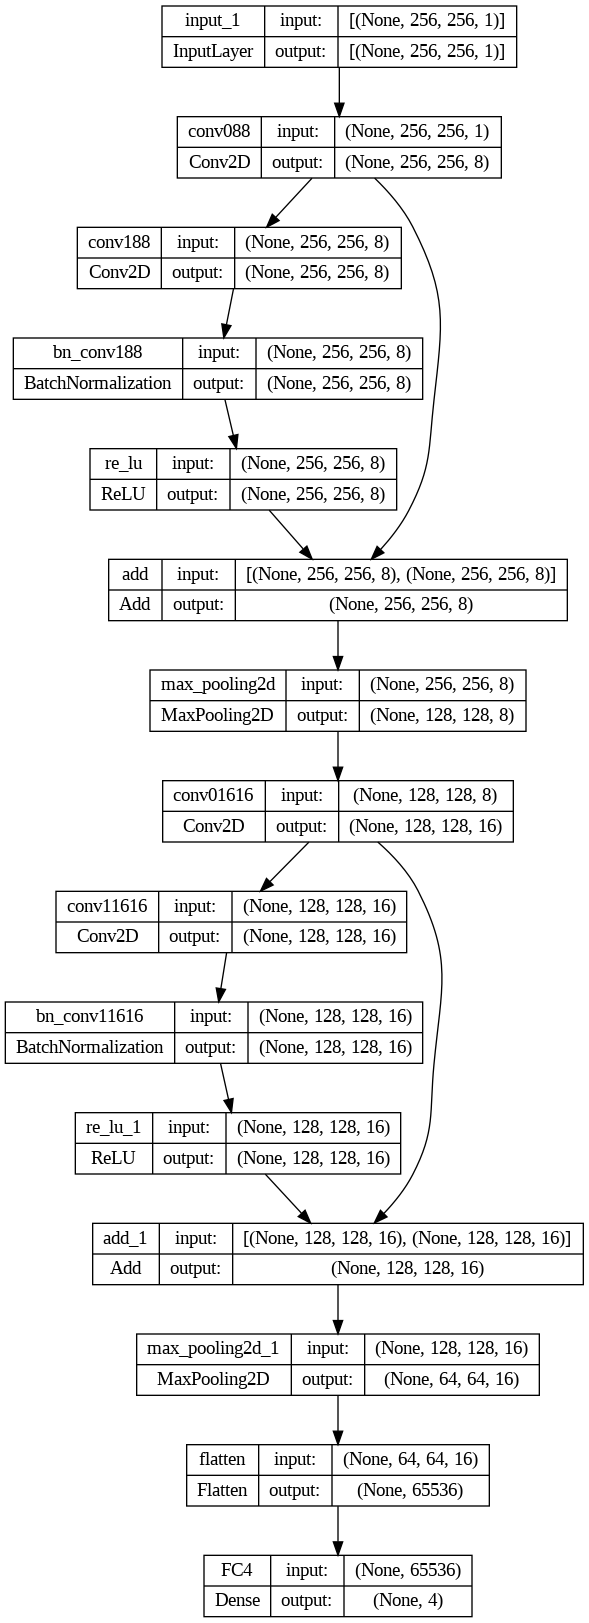

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor = 'val_loss',verbose=1,save_best_only=True,mode='auto',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=25)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=1e-10)
callbacks_list = [checkpoint,es,reduce_lr]

In [ ]:
# N=4
# for ival in range(N):
#     df_val = df_validacao[ival]
#     df_train = df_treino[ival]
#     history = model.fit(batch_generator(df_train, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
#                         steps_per_epoch=int(np.ceil(len(df_train)/batch_size)),
#                         epochs=100, verbose=1,
#                         callbacks=callbacks_list,
#                         validation_data=batch_generator(df_val, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
#                         validation_steps=int(np.ceil(len(df_val)/batch_size))
#                       )

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

#Fold 1

In [ ]:
    history = model.fit(batch_generator(df_treino_fold1, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold1)/batch_size)),
                        epochs=100, verbose=1,
                        shuffle=True,
                        callbacks=callbacks_list,
                        validation_data=batch_generator(df_fold1, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold1)/batch_size))
                      )

Epoch 1/100
366/366 [==============================] - ETA: 0s - loss: 0.5448 - acc: 0.9420 - auc: 0.9813 - precision: 0.9443 - recall: 0.9412
Epoch 1: val_loss improved from inf to 2.06850, saving model to model-001.model
366/366 [==============================] - 68s 148ms/step - loss: 0.5448 - acc: 0.9420 - auc: 0.9813 - precision: 0.9443 - recall: 0.9412 - val_loss: 2.0685 - val_acc: 0.4698 - val_auc: 0.7510 - val_precision: 0.4740 - val_recall: 0.4590 - lr: 0.0010
Epoch 2/100
365/366 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9911 - auc: 0.9984 - precision: 0.9911 - recall: 0.9908
Epoch 2: val_loss did not improve from 2.06850
366/366 [==============================] - 38s 105ms/step - loss: 0.0469 - acc: 0.9911 - auc: 0.9984 - precision: 0.9911 - recall: 0.9908 - val_loss: 2.4043 - val_acc: 0.6440 - val_auc: 0.8178 - val_precision: 0.6466 - val_recall: 0.6422 - lr: 0.0010
Epoch 3/100
365/366 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 

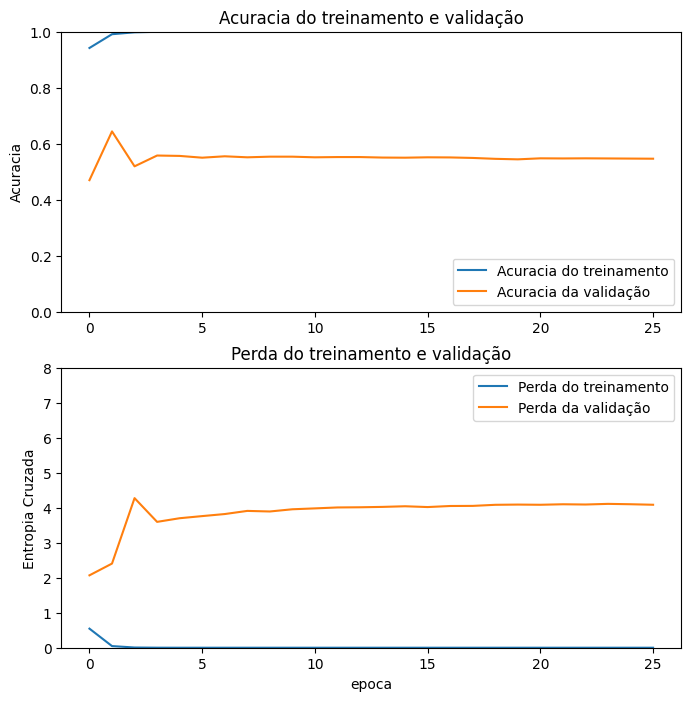

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

# Último modelo treinado

In [ ]:
model.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 20ms/step - loss: 9.9362 - acc: 0.3141 - auc: 0.5624 - precision: 0.3146 - recall: 0.3137


[9.9362211227417,
 0.31406843662261963,
 0.562403678894043,
 0.31464532017707825,
 0.3136882185935974]

83/83 [==============================] - 1s 15ms/step


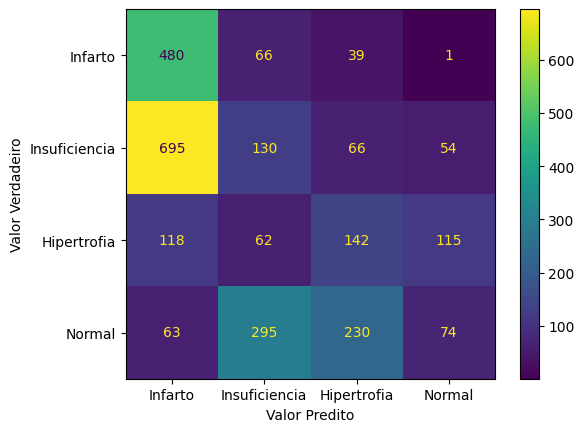

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3540    0.8191    0.4943       586
           1     0.2351    0.1376    0.1736       945
           2     0.2977    0.3249    0.3107       437
           3     0.3033    0.1118    0.1634       662

    accuracy                         0.3141      2630
   macro avg     0.2975    0.3484    0.2855      2630
weighted avg     0.2891    0.3141    0.2653      2630



#Último modelo salvo

In [ ]:
model1 = ResNetModel(include_top=True,
             input_tensor=None,
             input_shape=INPUT_SHAPE,
             pooling=None,
             classes=NUM_CLASSES)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'),
                      AUC(name='auc'),
                      Precision(name='precision'),
                      Recall(name='recall')]

In [ ]:
# compila do modelo
model1.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=metricasEscolhidas)

In [ ]:
from keras.models import load_model

In [ ]:
latest = tf.train.latest_checkpoint('./')
latest

'./model-001.model'

In [ ]:
# Load the previously saved weights
model1.load_weights(latest)

In [ ]:
model1.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv088 (Conv2D)               (None, 256, 256, 8)  80          ['input_2[0][0]']                
                                                                                                  
 conv188 (Conv2D)               (None, 256, 256, 8)  584         ['conv088[0][0]']                
                                                                                                  
 bn_conv188 (BatchNormalization  (None, 256, 256, 8)  32         ['conv188[0][0]']           

In [ ]:
model1.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 18ms/step - loss: 5.4400 - acc: 0.2924 - auc: 0.5091 - precision: 0.2889 - recall: 0.2814


[5.440008163452148,
 0.2923954427242279,
 0.5091427564620972,
 0.2889496386051178,
 0.28136882185935974]

83/83 [==============================] - 2s 16ms/step


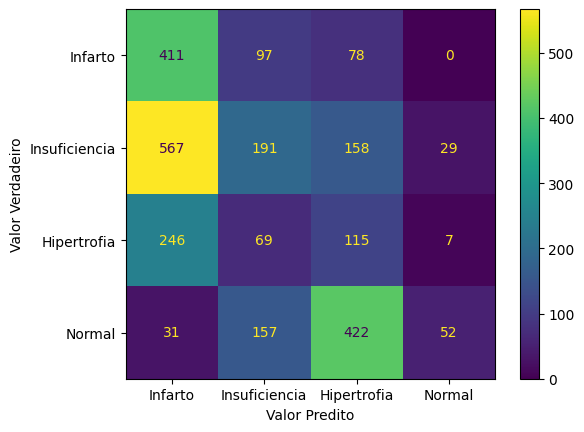

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model1.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3275    0.7014    0.4465       586
           1     0.3716    0.2021    0.2618       945
           2     0.1488    0.2632    0.1901       437
           3     0.5909    0.0785    0.1387       662

    accuracy                         0.2924      2630
   macro avg     0.3597    0.3113    0.2593      2630
weighted avg     0.3799    0.2924    0.2601      2630



#Fold2

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.001)

In [ ]:
    history = model.fit(batch_generator(df_treino_fold2, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold2)/batch_size)),
                        epochs=100, verbose=1,
                        callbacks=callbacks_list,
                        shuffle=True,
                        validation_data=batch_generator(df_fold2, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold2)/batch_size))
                      )

Epoch 1/100
354/354 [==============================] - ETA: 0s - loss: 0.8620 - acc: 0.9603 - auc: 0.9805 - precision: 0.9603 - recall: 0.9603
Epoch 1: val_loss did not improve from 2.06850
354/354 [==============================] - 42s 120ms/step - loss: 0.8620 - acc: 0.9603 - auc: 0.9805 - precision: 0.9603 - recall: 0.9603 - val_loss: 11.7993 - val_acc: 0.5231 - val_auc: 0.7110 - val_precision: 0.5229 - val_recall: 0.5227 - lr: 0.0010
Epoch 2/100
353/354 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9970 - auc: 0.9990 - precision: 0.9970 - recall: 0.9970
Epoch 2: val_loss did not improve from 2.06850
354/354 [==============================] - 33s 94ms/step - loss: 0.0211 - acc: 0.9969 - auc: 0.9990 - precision: 0.9969 - recall: 0.9969 - val_loss: 15.3127 - val_acc: 0.4975 - val_auc: 0.6872 - val_precision: 0.4975 - val_recall: 0.4975 - lr: 0.0010
Epoch 3/100
353/354 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9983 - auc: 0.9995 - precision

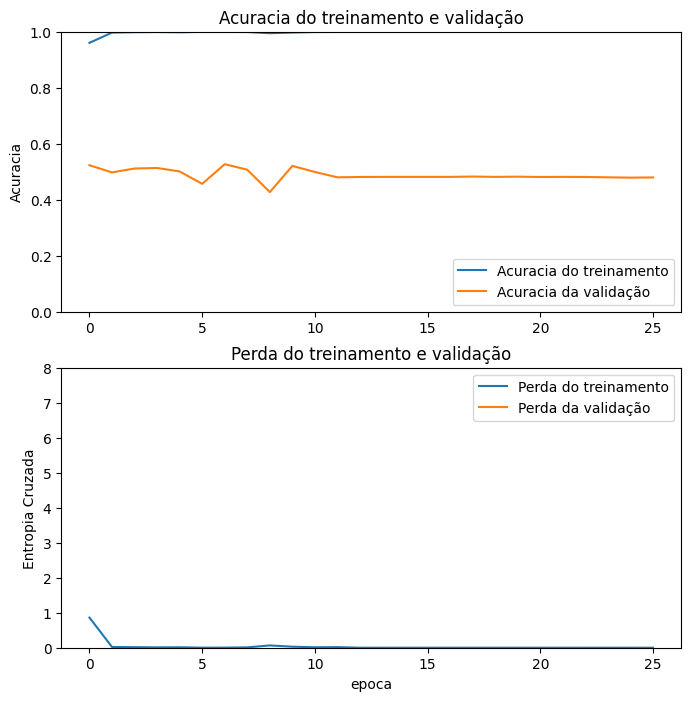

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

# Último modelo treinado

In [ ]:
model.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 20ms/step - loss: 44.8522 - acc: 0.3483 - auc: 0.5757 - precision: 0.3484 - recall: 0.3479


[44.85222625732422,
 0.34828898310661316,
 0.5757209062576294,
 0.34843868017196655,
 0.34790873527526855]

83/83 [==============================] - 1s 16ms/step


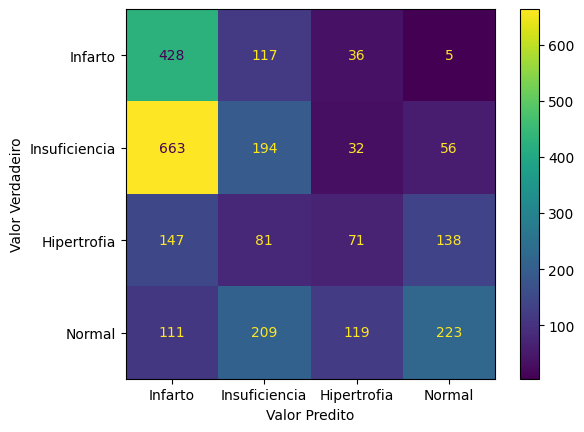

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3173    0.7304    0.4424       586
           1     0.3228    0.2053    0.2510       945
           2     0.2752    0.1625    0.2043       437
           3     0.5284    0.3369    0.4114       662

    accuracy                         0.3483      2630
   macro avg     0.3609    0.3587    0.3273      2630
weighted avg     0.3654    0.3483    0.3263      2630



#Último modelo salvo

In [ ]:
model1 = ResNetModel(include_top=True,
             input_tensor=None,
             input_shape=INPUT_SHAPE,
             pooling=None,
             classes=NUM_CLASSES)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'),
                      AUC(name='auc'),
                      Precision(name='precision'),
                      Recall(name='recall')]

In [ ]:
# compila do modelo
model1.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=metricasEscolhidas)

In [ ]:
from keras.models import load_model

In [ ]:
latest = tf.train.latest_checkpoint('./')
latest

'./model-001.model'

In [ ]:
# Load the previously saved weights
model1.load_weights(latest)

In [ ]:
model1.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv088 (Conv2D)               (None, 256, 256, 8)  80          ['input_3[0][0]']                
                                                                                                  
 conv188 (Conv2D)               (None, 256, 256, 8)  584         ['conv088[0][0]']                
                                                                                                  
 bn_conv188 (BatchNormalization  (None, 256, 256, 8)  32         ['conv188[0][0]']           

In [ ]:
model1.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 18ms/step - loss: 5.4400 - acc: 0.2924 - auc: 0.5091 - precision: 0.2889 - recall: 0.2814


[5.440008163452148,
 0.2923954427242279,
 0.5091427564620972,
 0.2889496386051178,
 0.28136882185935974]

83/83 [==============================] - 1s 14ms/step


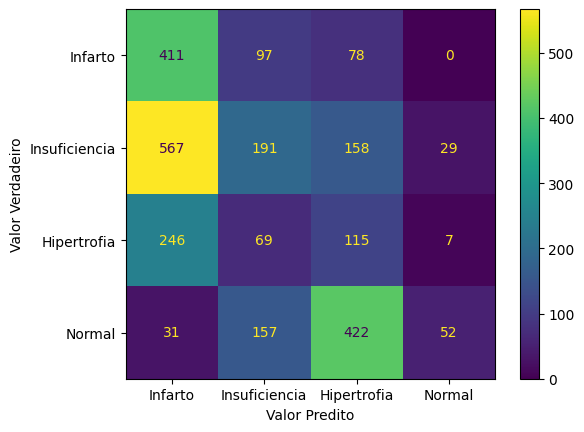

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model1.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3275    0.7014    0.4465       586
           1     0.3716    0.2021    0.2618       945
           2     0.1488    0.2632    0.1901       437
           3     0.5909    0.0785    0.1387       662

    accuracy                         0.2924      2630
   macro avg     0.3597    0.3113    0.2593      2630
weighted avg     0.3799    0.2924    0.2601      2630



#Fold 3

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.001)

In [ ]:
    history = model.fit(batch_generator(df_treino_fold3, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold3)/batch_size)),
                        epochs=100, verbose=1,
                        callbacks=callbacks_list,
                        shuffle=True,
                        validation_data=batch_generator(df_fold3, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold3)/batch_size))
                      )

Epoch 1/100
373/373 [==============================] - ETA: 0s - loss: 0.2924 - acc: 0.9868 - auc: 0.9931 - precision: 0.9868 - recall: 0.9868
Epoch 1: val_loss did not improve from 2.06850
373/373 [==============================] - 52s 139ms/step - loss: 0.2924 - acc: 0.9868 - auc: 0.9931 - precision: 0.9868 - recall: 0.9868 - val_loss: 5.6896 - val_acc: 0.8129 - val_auc: 0.8845 - val_precision: 0.8129 - val_recall: 0.8129 - lr: 0.0010
Epoch 2/100
372/373 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9982 - auc: 0.9994 - precision: 0.9982 - recall: 0.9982
Epoch 2: val_loss did not improve from 2.06850
373/373 [==============================] - 39s 104ms/step - loss: 0.0182 - acc: 0.9982 - auc: 0.9994 - precision: 0.9982 - recall: 0.9982 - val_loss: 4.9554 - val_acc: 0.8440 - val_auc: 0.9087 - val_precision: 0.8440 - val_recall: 0.8440 - lr: 0.0010
Epoch 3/100
372/373 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9987 - auc: 0.9993 - precision:

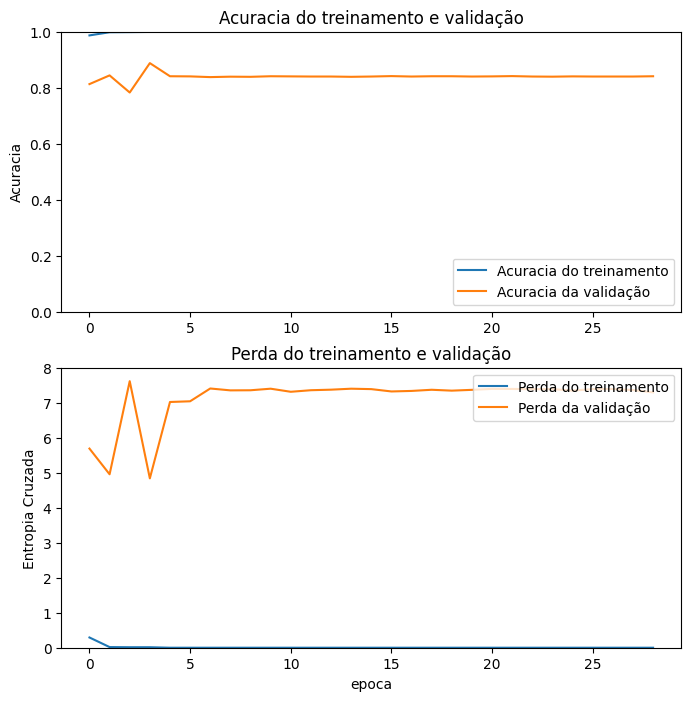

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

## Matheus, usar o seguinte resultado

# Último modelo treinado

In [ ]:
model.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 19ms/step - loss: 47.5088 - acc: 0.3456 - auc: 0.5716 - precision: 0.3459 - recall: 0.3456


[47.50883483886719,
 0.3456273674964905,
 0.571571946144104,
 0.3458904027938843,
 0.3456273674964905]

83/83 [==============================] - 1s 15ms/step


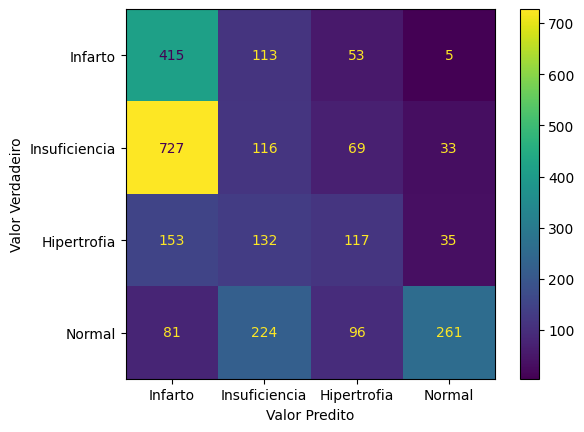

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3016    0.7082    0.4230       586
           1     0.1983    0.1228    0.1516       945
           2     0.3493    0.2677    0.3031       437
           3     0.7814    0.3943    0.5241       662

    accuracy                         0.3456      2630
   macro avg     0.4076    0.3732    0.3505      2630
weighted avg     0.3932    0.3456    0.3310      2630



# Até Aqui

#Último modelo salvo

In [ ]:
model1 = ResNetModel(include_top=True,
             input_tensor=None,
             input_shape=INPUT_SHAPE,
             pooling=None,
             classes=NUM_CLASSES)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'),
                      AUC(name='auc'),
                      Precision(name='precision'),
                      Recall(name='recall')]

In [ ]:
# compila do modelo
model1.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=metricasEscolhidas)

In [ ]:
from keras.models import load_model

In [ ]:
# latest = tf.train.latest_checkpoint('./')
# latest

In [ ]:
latest = tf.train.latest_checkpoint('./')
latest

'./model-001.model'

In [ ]:
# Load the previously saved weights
model1.load_weights(latest)

In [ ]:
model1.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv088 (Conv2D)               (None, 256, 256, 8)  80          ['input_4[0][0]']                
                                                                                                  
 conv188 (Conv2D)               (None, 256, 256, 8)  584         ['conv088[0][0]']                
                                                                                                  
 bn_conv188 (BatchNormalization  (None, 256, 256, 8)  32         ['conv188[0][0]']           

In [ ]:
model1.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 20ms/step - loss: 5.4400 - acc: 0.2924 - auc: 0.5091 - precision: 0.2889 - recall: 0.2814


[5.440008163452148,
 0.2923954427242279,
 0.5091427564620972,
 0.2889496386051178,
 0.28136882185935974]

83/83 [==============================] - 1s 15ms/step


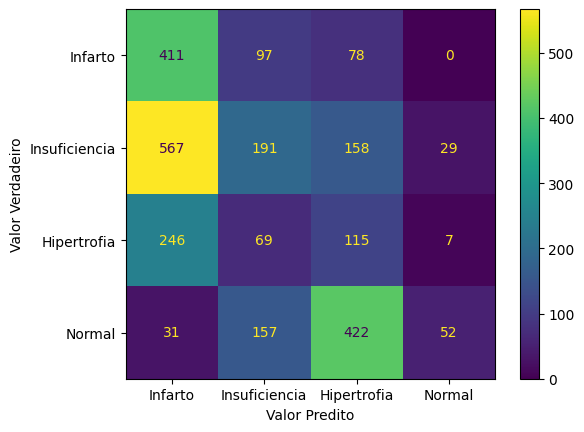

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model1.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3275    0.7014    0.4465       586
           1     0.3716    0.2021    0.2618       945
           2     0.1488    0.2632    0.1901       437
           3     0.5909    0.0785    0.1387       662

    accuracy                         0.2924      2630
   macro avg     0.3597    0.3113    0.2593      2630
weighted avg     0.3799    0.2924    0.2601      2630



#Fold 4

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.001)

In [ ]:
    history = model.fit(batch_generator(df_treino_fold4, batch_size, _mode='train', label_set=rotulo, tam_img=tam_img),
                        steps_per_epoch=int(np.ceil(len(df_treino_fold4)/batch_size)),
                        epochs=100, verbose=1,
                        callbacks=callbacks_list,
                        shuffle=True,
                        validation_data=batch_generator(df_fold4, batch_size, _mode='val', label_set=rotulo, tam_img=tam_img),
                        validation_steps=int(np.ceil(len(df_fold4)/batch_size))
                      )

Epoch 1/100
369/370 [============================>.] - ETA: 0s - loss: 0.2838 - acc: 0.9906 - auc: 0.9951 - precision: 0.9906 - recall: 0.9906
Epoch 1: val_loss improved from 2.06850 to 0.54937, saving model to model-001.model
370/370 [==============================] - 34s 93ms/step - loss: 0.2833 - acc: 0.9906 - auc: 0.9951 - precision: 0.9906 - recall: 0.9906 - val_loss: 0.5494 - val_acc: 0.9786 - val_auc: 0.9883 - val_precision: 0.9786 - val_recall: 0.9786 - lr: 0.0010
Epoch 2/100
369/370 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9993 - auc: 0.9997 - precision: 0.9993 - recall: 0.9993
Epoch 2: val_loss improved from 0.54937 to 0.10832, saving model to model-002.model
370/370 [==============================] - 41s 110ms/step - loss: 0.0130 - acc: 0.9993 - auc: 0.9997 - precision: 0.9993 - recall: 0.9993 - val_loss: 0.1083 - val_acc: 0.9888 - val_auc: 0.9954 - val_precision: 0.9888 - val_recall: 0.9888 - lr: 0.0010
Epoch 3/100
369/370 [========================

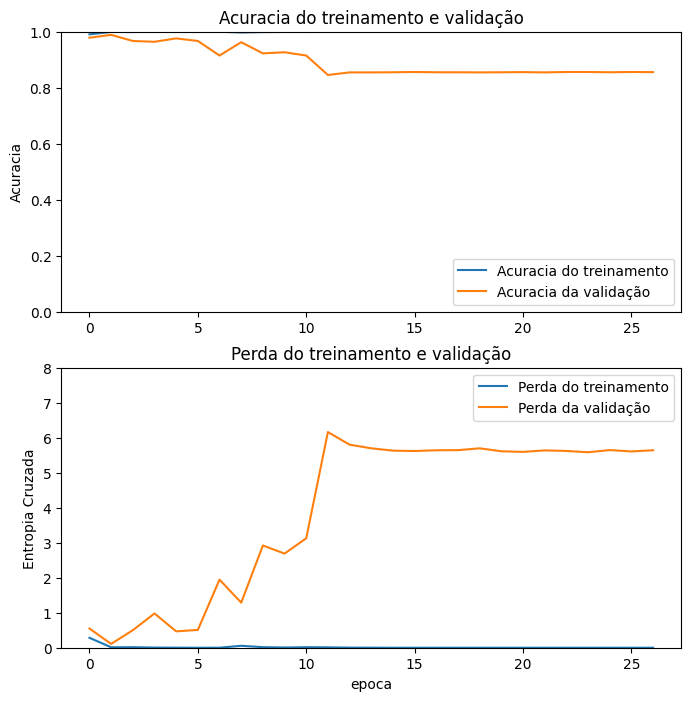

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

# Último modelo treinado

In [ ]:
model.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 19ms/step - loss: 110.8631 - acc: 0.2422 - auc: 0.4941 - precision: 0.2422 - recall: 0.2422


[110.86312103271484,
 0.24220532178878784,
 0.4941323697566986,
 0.24220532178878784,
 0.24220532178878784]

83/83 [==============================] - 1s 17ms/step


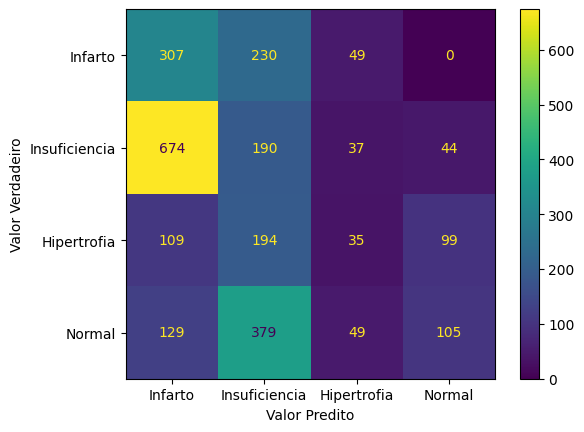

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.2518    0.5239    0.3402       586
           1     0.1913    0.2011    0.1961       945
           2     0.2059    0.0801    0.1153       437
           3     0.4234    0.1586    0.2308       662

    accuracy                         0.2422      2630
   macro avg     0.2681    0.2409    0.2206      2630
weighted avg     0.2656    0.2422    0.2235      2630



#Último modelo salvo

In [ ]:
model1 = ResNetModel(include_top=True,
             input_tensor=None,
             input_shape=INPUT_SHAPE,
             pooling=None,
             classes=NUM_CLASSES)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'),
                      AUC(name='auc'),
                      Precision(name='precision'),
                      Recall(name='recall')]

In [ ]:
# compila do modelo
model1.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=metricasEscolhidas)

In [ ]:
from keras.models import load_model

In [ ]:
latest = tf.train.latest_checkpoint('./')
latest

'./model-002.model'

In [ ]:
# Load the previously saved weights
model1.load_weights(latest)

In [ ]:
model1.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv088 (Conv2D)               (None, 256, 256, 8)  80          ['input_5[0][0]']                
                                                                                                  
 conv188 (Conv2D)               (None, 256, 256, 8)  584         ['conv088[0][0]']                
                                                                                                  
 bn_conv188 (BatchNormalization  (None, 256, 256, 8)  32         ['conv188[0][0]']           

In [ ]:
model1.evaluate(data_teste,target_teste)

83/83 [==============================] - 2s 19ms/step - loss: 66.4286 - acc: 0.3160 - auc: 0.5483 - precision: 0.3163 - recall: 0.3160


[66.42861938476562,
 0.3159695863723755,
 0.5482553839683533,
 0.3163304030895233,
 0.3159695863723755]

83/83 [==============================] - 1s 15ms/step


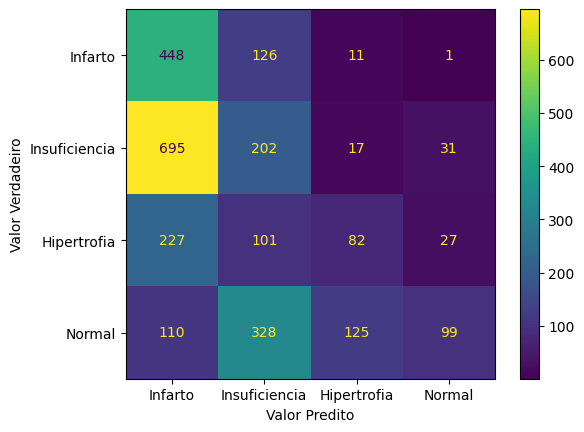

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model1.predict(data_teste)

y_true = [np.argmax(y, axis=None, out=None) for y in target_teste]
y_true = np.array(y_true)

y_hat = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_hat = np.array(y_hat)

confusion = confusion_matrix(y_true, y_hat)


ConfusionMatrixDisplay(confusion, display_labels=rotulo).plot()
plt.grid(False)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.3027    0.7645    0.4337       586
           1     0.2668    0.2138    0.2374       945
           2     0.3489    0.1876    0.2440       437
           3     0.6266    0.1495    0.2415       662

    accuracy                         0.3160      2630
   macro avg     0.3863    0.3289    0.2891      2630
weighted avg     0.3790    0.3160    0.2833      2630

